In [15]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [16]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [17]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [18]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 

In [19]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    cv2.namedWindow("opencv feed", cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty("opencv feed", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    while cap.isOpened():
        ret,frame= cap.read()
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        draw_landmarks(image,results)
        cv2.imshow("opencv feed",frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [20]:
plt.imshow(frame)

NameError: name 'frame' is not defined

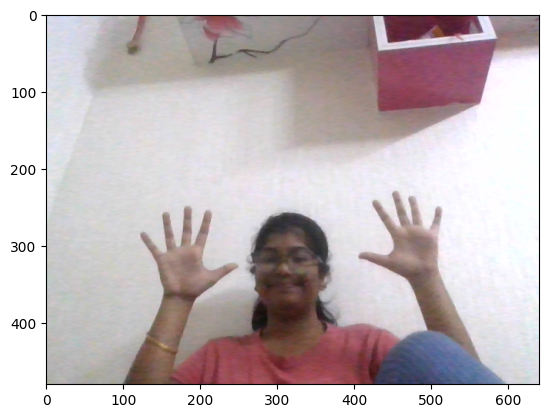

In [12]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

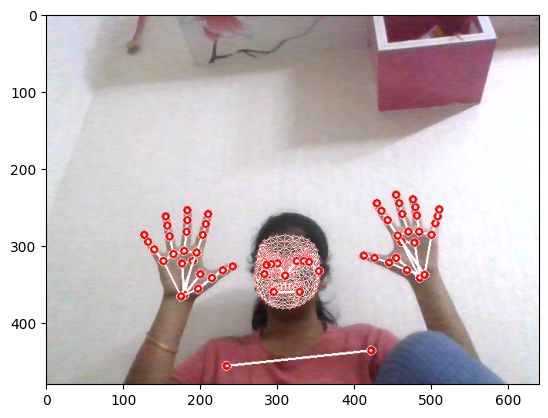

In [13]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [95]:
def extract_keypoints(results):
    aks=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    fks=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*4)
    lks=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rks=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([aks,fks,lks,rks])

In [96]:
extract_keypoints(results).shape

(1662,)

In [98]:
result_test=extract_keypoints(results)
np.save('0',result_test)

In [99]:
np.load('0.npy')

array([ 0.62290299,  0.54169047, -1.07671356, ...,  0.28372592,
        0.81647801, -0.11199041])

In [13]:
DATA_PATH = 'DATA'
actions = np.array(['hello', 'yes', 'no'])
no_sequences = 30
sequence_length = 30

for a in actions:
    for i in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, a, str(i)))
        except:
            pass


In [14]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    for a in actions:
        for i in range(no_sequences):
            for frame_num in range(sequence_length):
                ret,frame= cap.read()
                image,results = mediapipe_detection(frame,holistic)
                print(results)
                draw_landmarks(image,results)
                if frame_num==0:
                    cv2.putText(image,'starting',(120,200),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),1,cv2.LINE_AA)
                    cv2.putText(image,'collecting frames for {} Video number {} '.format(a,i),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(3000)
                else:
                    cv2.putText(image,'collecting frames for {} Video number {} '.format(a,i),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                
                kp = extract_keypoints(results)
                npp=os.path.join(DATA_PATH,a,str(i),str(frame_num))
                np.save(npp,kp)
                cv2.imshow("opencv feed",image)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
label_map = {label:num for num, label in enumerate(actions)}
label_map

NameError: name 'actions' is not defined

In [ ]:
sequences , labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window=[]
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,a,str(i),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [103]:
x= np.array(sequences)

In [104]:
y = to_categorical(labels).astype(int)

In [105]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.5)

In [106]:
y_train.shape

(45, 3)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [121]:
log_dir = os.path.join('Log')
tb_callback = TensorBoard(log_dir=log_dir)

In [10]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,2130)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

NameError: name 'actions' is not defined

In [169]:
res = [.7, 0.2, 0.1]


In [170]:
actions[np.argmax(res)]


'hello'

In [7]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


NameError: name 'model' is not defined

In [152]:
model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])


Epoch 1/2000
2/2 [==============================] - 17s 232ms/step - loss: 2.8509 - categorical_accuracy: 0.3556
Epoch 2/2000
2/2 [==============================] - 1s 1s/step - loss: 4.4810 - categorical_accuracy: 0.3556
Epoch 3/2000
2/2 [==============================] - 0s 160ms/step - loss: 3.6614 - categorical_accuracy: 0.3556
Epoch 4/2000
2/2 [==============================] - 0s 163ms/step - loss: 18.9816 - categorical_accuracy: 0.2667
Epoch 5/2000
2/2 [==============================] - 0s 147ms/step - loss: 30.4876 - categorical_accuracy: 0.2889
Epoch 6/2000
2/2 [==============================] - 1s 1s/step - loss: 18.0874 - categorical_accuracy: 0.3333
Epoch 7/2000
2/2 [==============================] - 1s 855ms/step - loss: 15.5050 - categorical_accuracy: 0.2667
Epoch 8/2000
2/2 [==============================] - 0s 143ms/step - loss: 26.7350 - categorical_accuracy: 0.3556
Epoch 9/2000
2/2 [==============================] - 0s 158ms/step - loss: 3.8245 - categorical_accuracy:

In [6]:
model.summary()

NameError: name 'model' is not defined

In [5]:
res =model.predict(x_test)

NameError: name 'model' is not defined

In [174]:
actions[np.argmax((res[1]))]

'yes'

In [175]:
actions[np.argmax(y_test[1])]


'yes'

In [176]:
model.save('action.h5')

In [177]:
model.load_weights('action.h5')

In [178]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [189]:
yhat = model.predict(x_train)


2/2 [==============================] - 0s 38ms/step


In [190]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()


In [191]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[29,  0],
        [16,  0]],

       [[ 0, 29],
        [ 0, 16]],

       [[32,  0],
        [13,  0]]], dtype=int64)

In [195]:
accuracy_score(ytrue, yhat)


0.35555555555555557

In [1]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [4]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'res' is not defined

<Figure size 1800x1800 with 0 Axes>